In [1]:
import os
import sys
import torch
import inspect
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm
import matplotlib.patches as mpatchesP
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from matplotlib.legend_handler import HandlerPatch
warnings.filterwarnings("ignore")

def jump_up_one_dir():
    new_dir = Path().resolve().parent
    os.chdir(new_dir)
    print("✅ 当前工作目录跳转至:", new_dir)

jump_up_one_dir()

✅ 当前工作目录跳转至: C:\Users\Jeming\Desktop\T0


In [6]:
# 此时，所需要使用的数据可以选择相对路径
font_path = './set word/Arial/Arial.ttf'  # 需要修改
fm.fontManager.addfont(font_path)
print("✅ 字体已添加:", font_path)

# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18 
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

✅ 字体已添加: ./set word/Arial/Arial.ttf


In [7]:
# 导入数据
file_fold = './0-dataset/'  
adata_omics1_raw = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2_raw = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics1_raw.var_names_make_unique()
adata_omics2_raw.var_names_make_unique()
print("✅ 数据已导入:", file_fold)

✅ 数据已导入: ./0-dataset/


### 图1：真实标签结果图

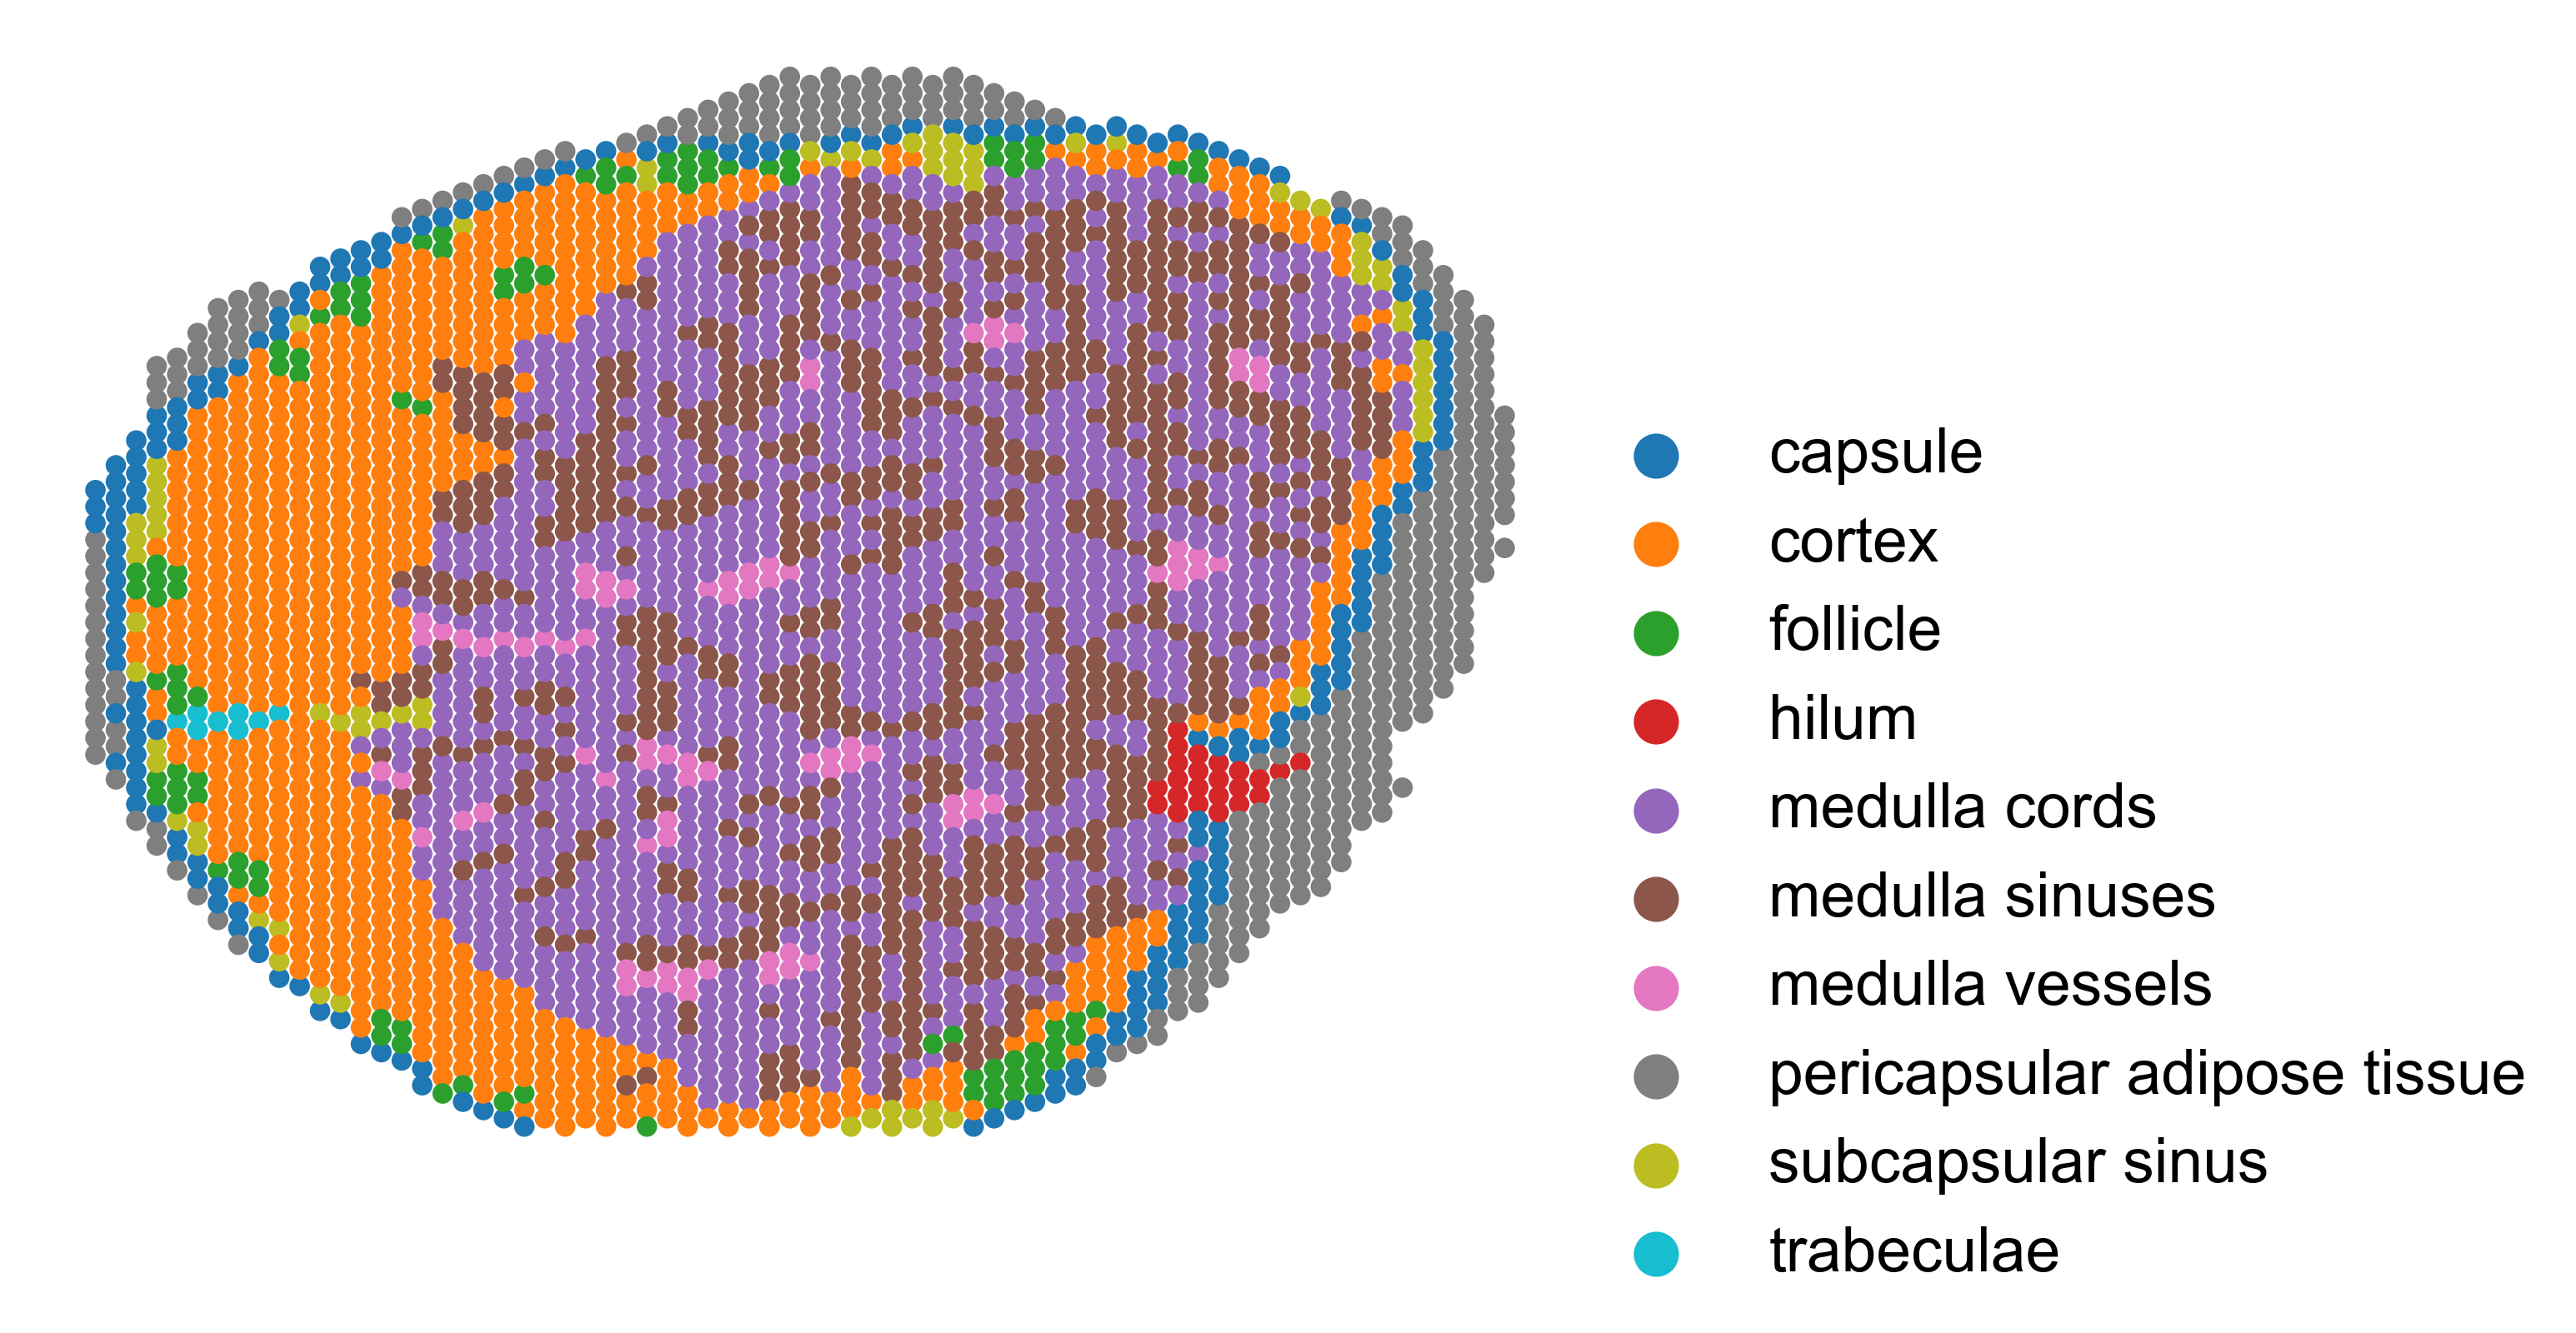

In [8]:
# 设置图的 DPI 和尺寸
dpi = 300
fig_width_inch = 8  # 图的宽度（英寸）
fig_height_inch = 6  # 图的高度（英寸）

# 创建图
fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch), dpi=dpi)
# fig.patch.set_facecolor('#F2FCFC')  # 整体背景色
# ax.set_facecolor('#F2FCFC')         # 坐标区域背景色

# 假设 spot 的物理直径为 1 毫米
spot_size_mm = 1
mm_per_inch = 25.4  # 每英寸的毫米数
spot_size_points = (spot_size_mm * dpi / mm_per_inch)  # 转换为点
s = spot_size_points ** 2  # 面积

# 绘图
sc.pl.embedding(adata_omics1_raw, basis='spatial', color='final_annot', 
                title='', s=s, ax=ax, show=False)

# 去掉边框和轴标签
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')


# 调整图例中圆圈的大小
ax.legend(markerscale=2,  # 调整图例中圆圈的大小
          loc='upper right',  # 图例位置
          frameon=False,  # 是否显示图例边框
          edgecolor=None,  # 图例边框颜色
          facecolor=None,  # 图例背景颜色
          bbox_to_anchor=(1.65, 0.7))  # 图例位置的微调
# 显示图
plt.show()

### 1-domain 展示

In [10]:
T1_size1 = pd.read_csv('./1-box/S1-results.csv', index_col=0)
T1_size2 = pd.read_csv('./1-box/S2-results.csv', index_col=0)
T1_size3 = pd.read_csv('./1-box/S3-results.csv', index_col=0)
print("✅ 结果已导入:", './1-box/S1-results.csv')
print("✅ 结果已导入:", './1-box/S2-results.csv')
print("✅ 结果已导入:", './1-box/S3-results.csv')


✅ 结果已导入: ./1-box/S1-results.csv
✅ 结果已导入: ./1-box/S2-results.csv
✅ 结果已导入: ./1-box/S3-results.csv


In [11]:
T1_size1

,AMI,V-measure,Homogeneity,NMI,ARI
COSMOS,0.081572,0.088119,0.085968,0.088119,0.056764
SpaMosaic,0.095062,0.100818,0.110365,0.100818,0.038426
MISO,0.240287,0.245241,0.251380,0.245241,0.115368
SpatialGlue,0.336750,0.341016,0.370337,0.341016,0.199309
Our Method,0.366627,0.370782,0.394567,0.370782,0.230132


In [14]:
# 模拟数据
# T1_size1
data1 = T1_size1
# T1_size2
data2 = T1_size2
# T1_size3
data3 = T1_size3
# 创建 DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# 合并 DataFrame
dfs = [df1, df2, df3]
result_df = pd.concat(dfs, keys=['T1_size1', 'T1_size2', 'T1_size3'])

# 转换为长格式
result_df = result_df.reset_index()
result_df = result_df.melt(id_vars=['level_0', 'level_1'], var_name='Metric', value_name='Value')
# 重命名列
result_df = result_df.rename(columns={'level_0': 'Size', 'level_1': 'Method'})
print("✅ 数据已合并:")
print(result_df)

✅ 数据已合并:
        Size       Method Metric     Value
0   T1_size1       COSMOS    AMI  0.081572
1   T1_size1    SpaMosaic    AMI  0.095062
2   T1_size1         MISO    AMI  0.240287
3   T1_size1  SpatialGlue    AMI  0.336750
4   T1_size1   Our Method    AMI  0.366627
..       ...          ...    ...       ...
70  T1_size3       COSMOS    ARI  0.011406
71  T1_size3    SpaMosaic    ARI  0.029772
72  T1_size3         MISO    ARI  0.136421
73  T1_size3  SpatialGlue    ARI  0.176916
74  T1_size3   Our Method    ARI  0.233741

[75 rows x 4 columns]


### 图2：柱状图（带散点）

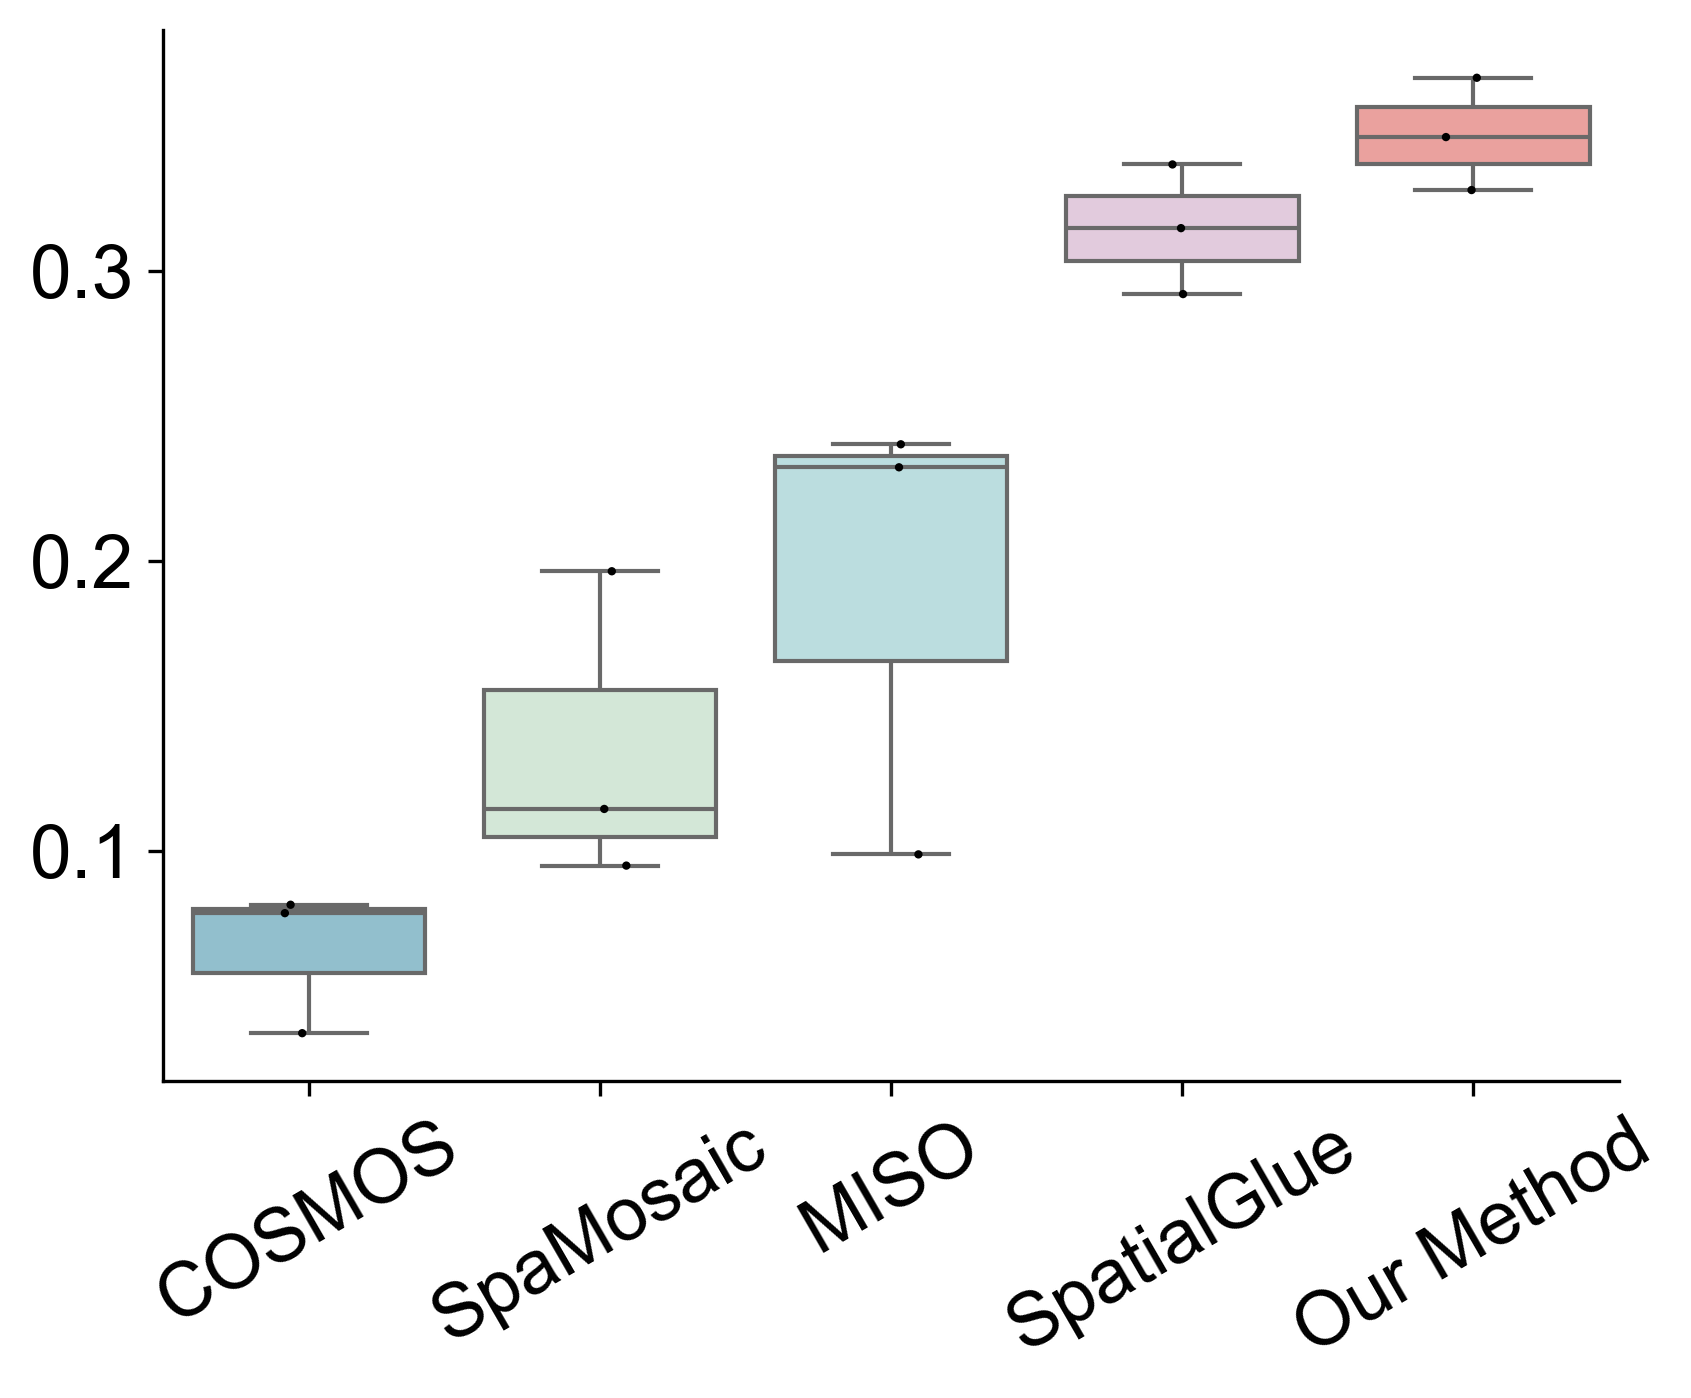

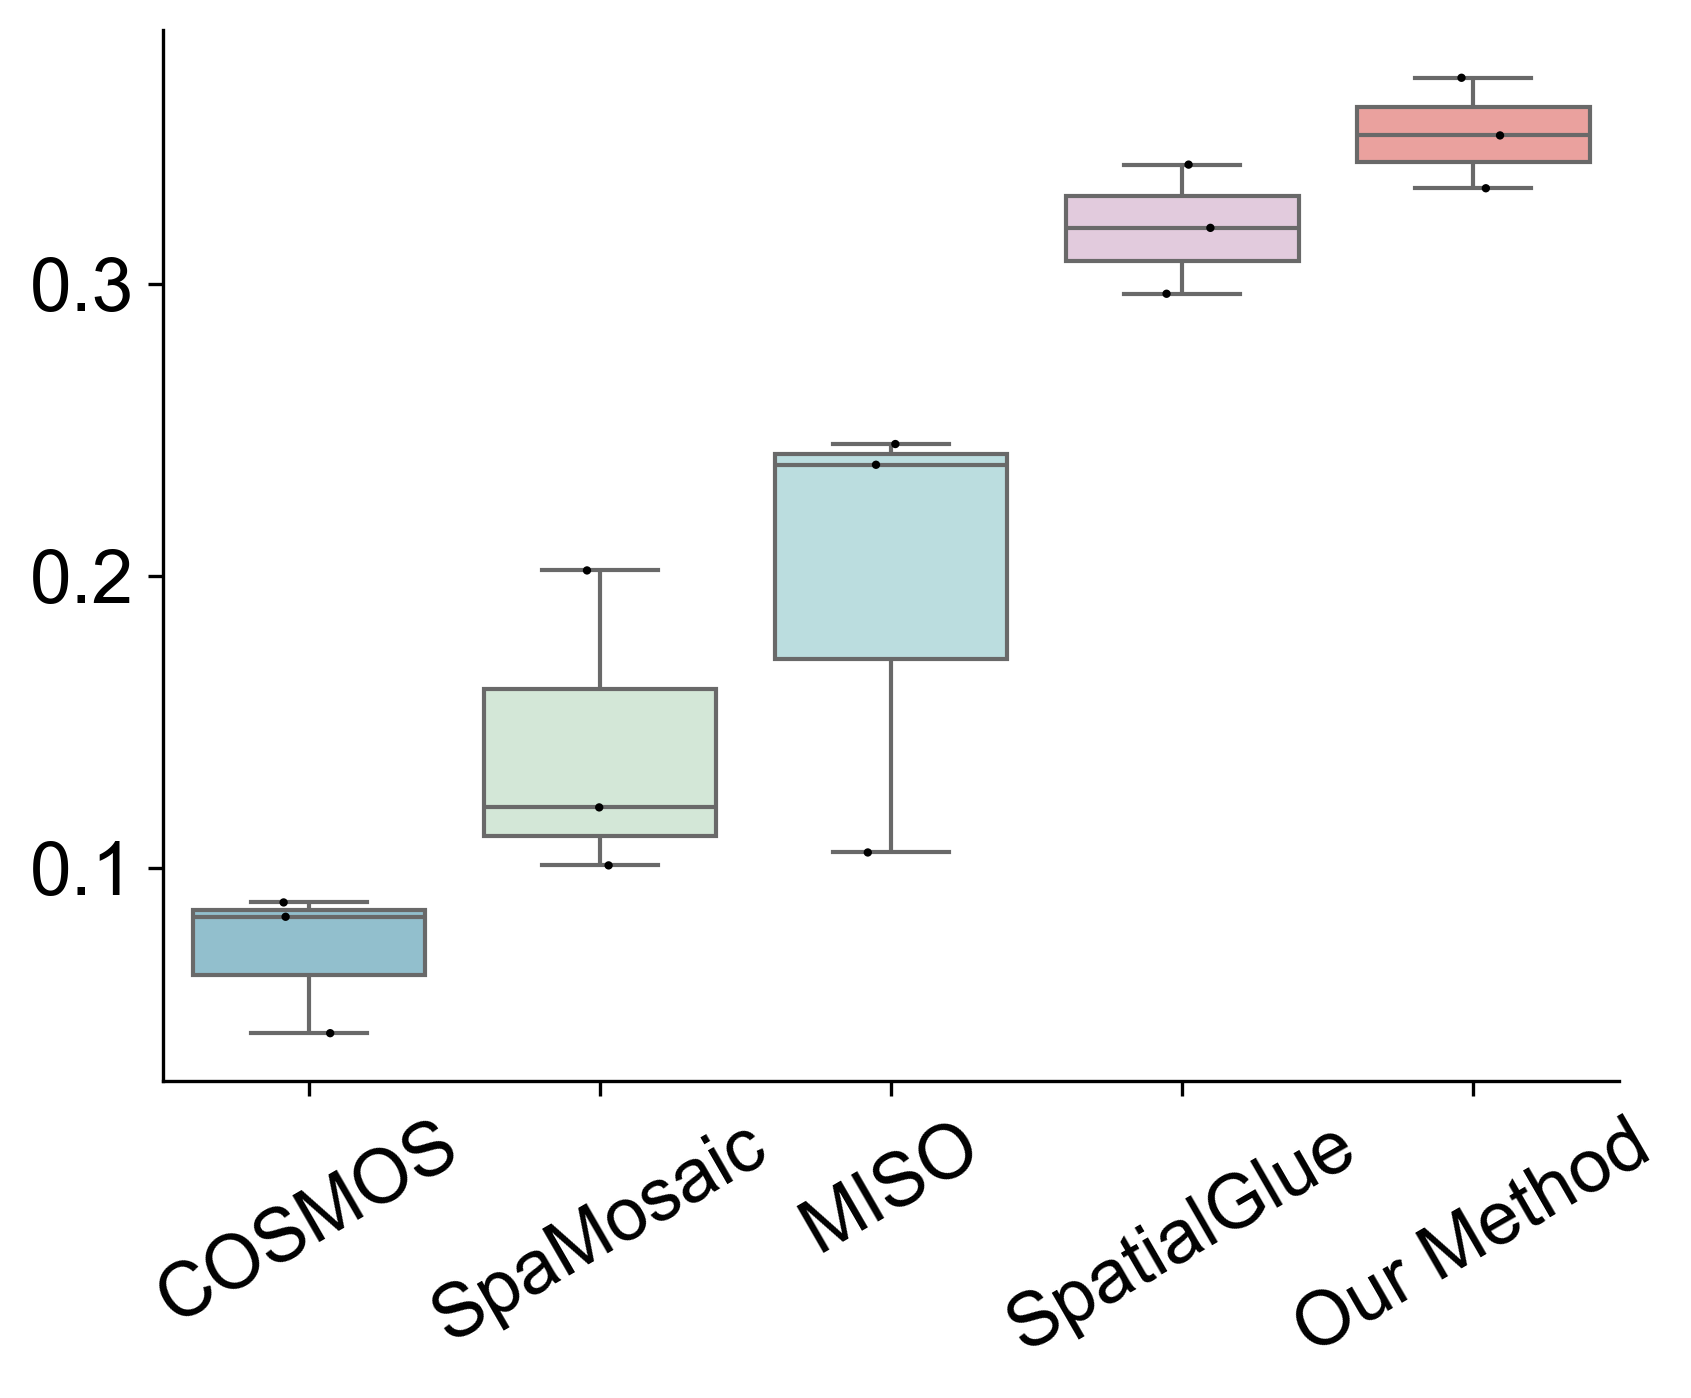

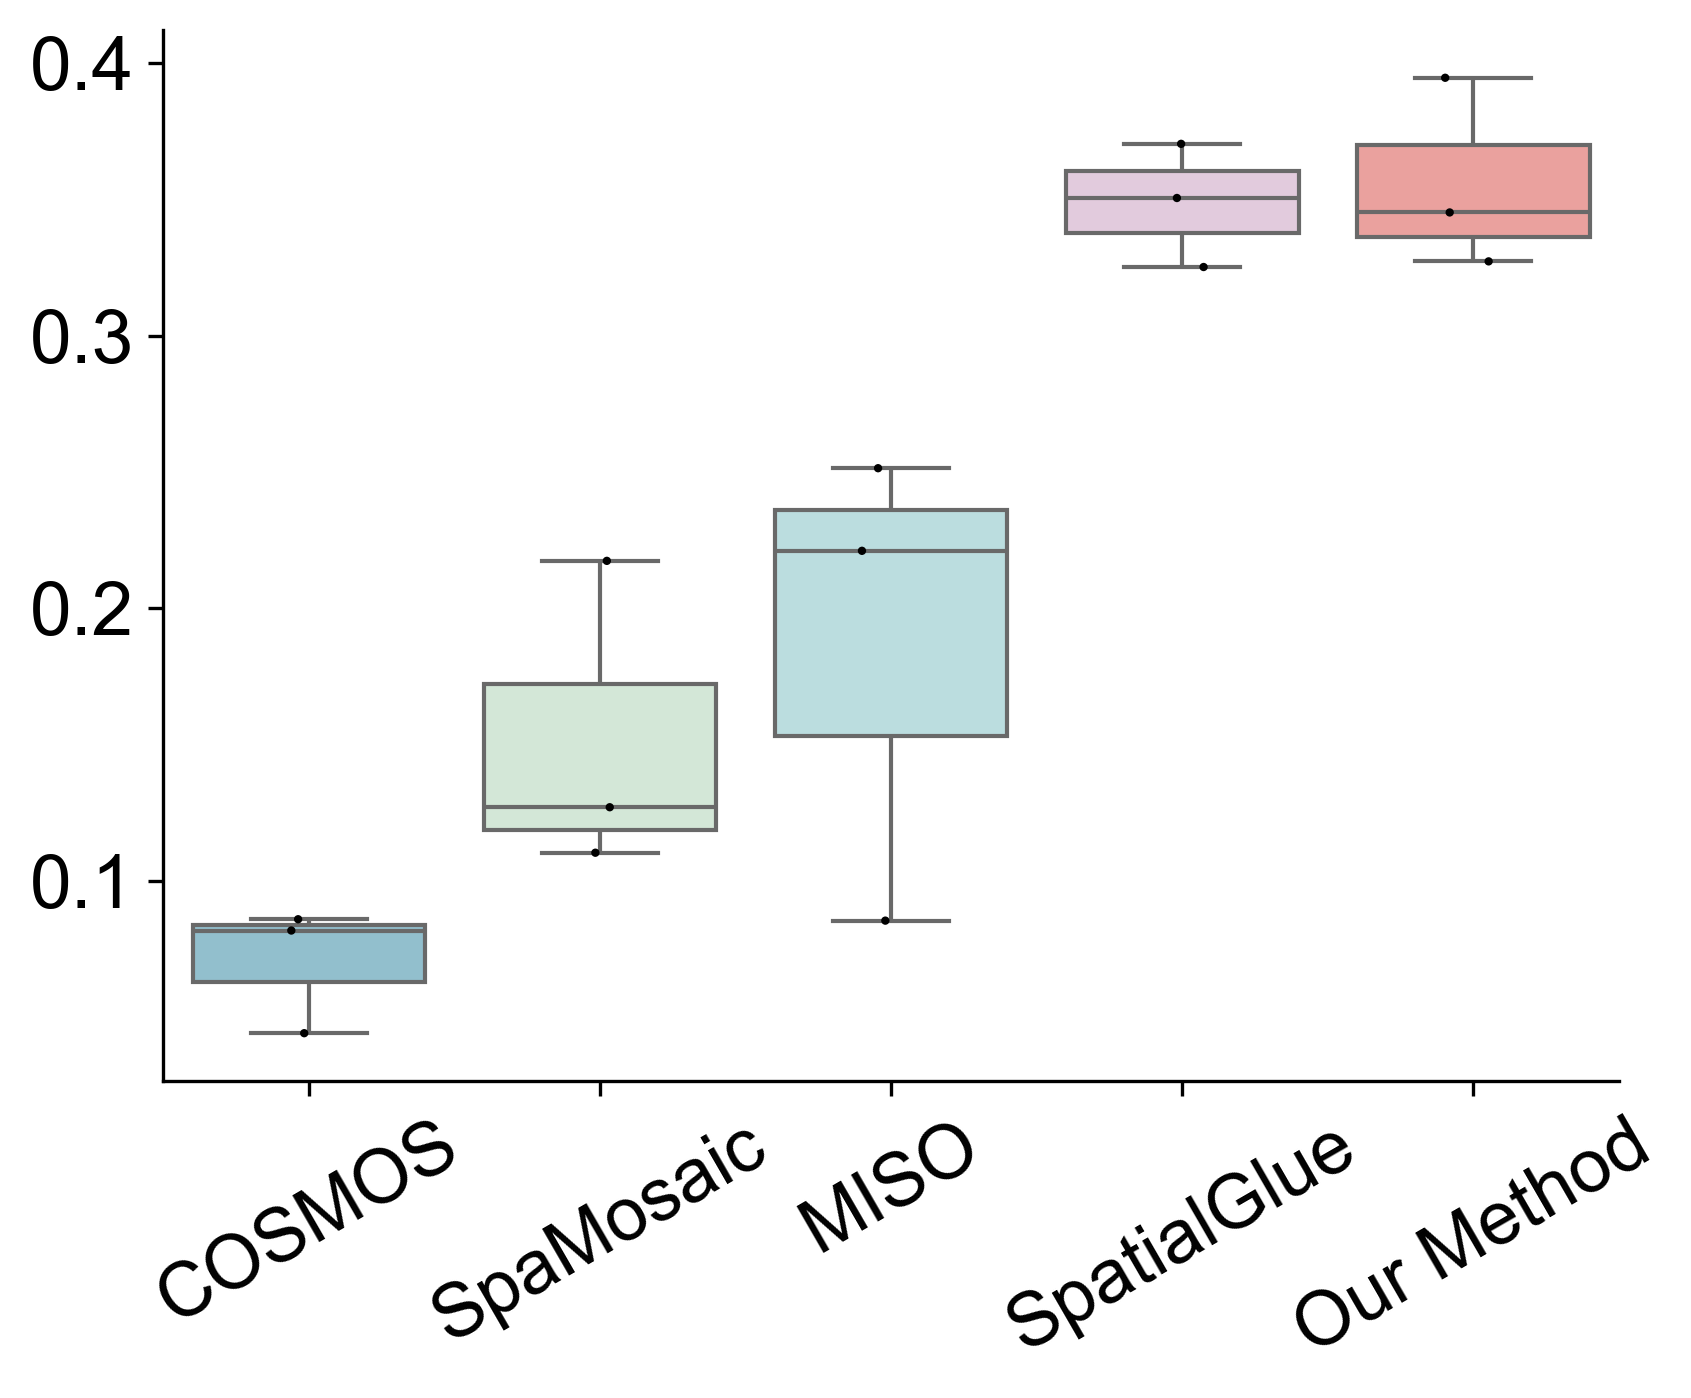

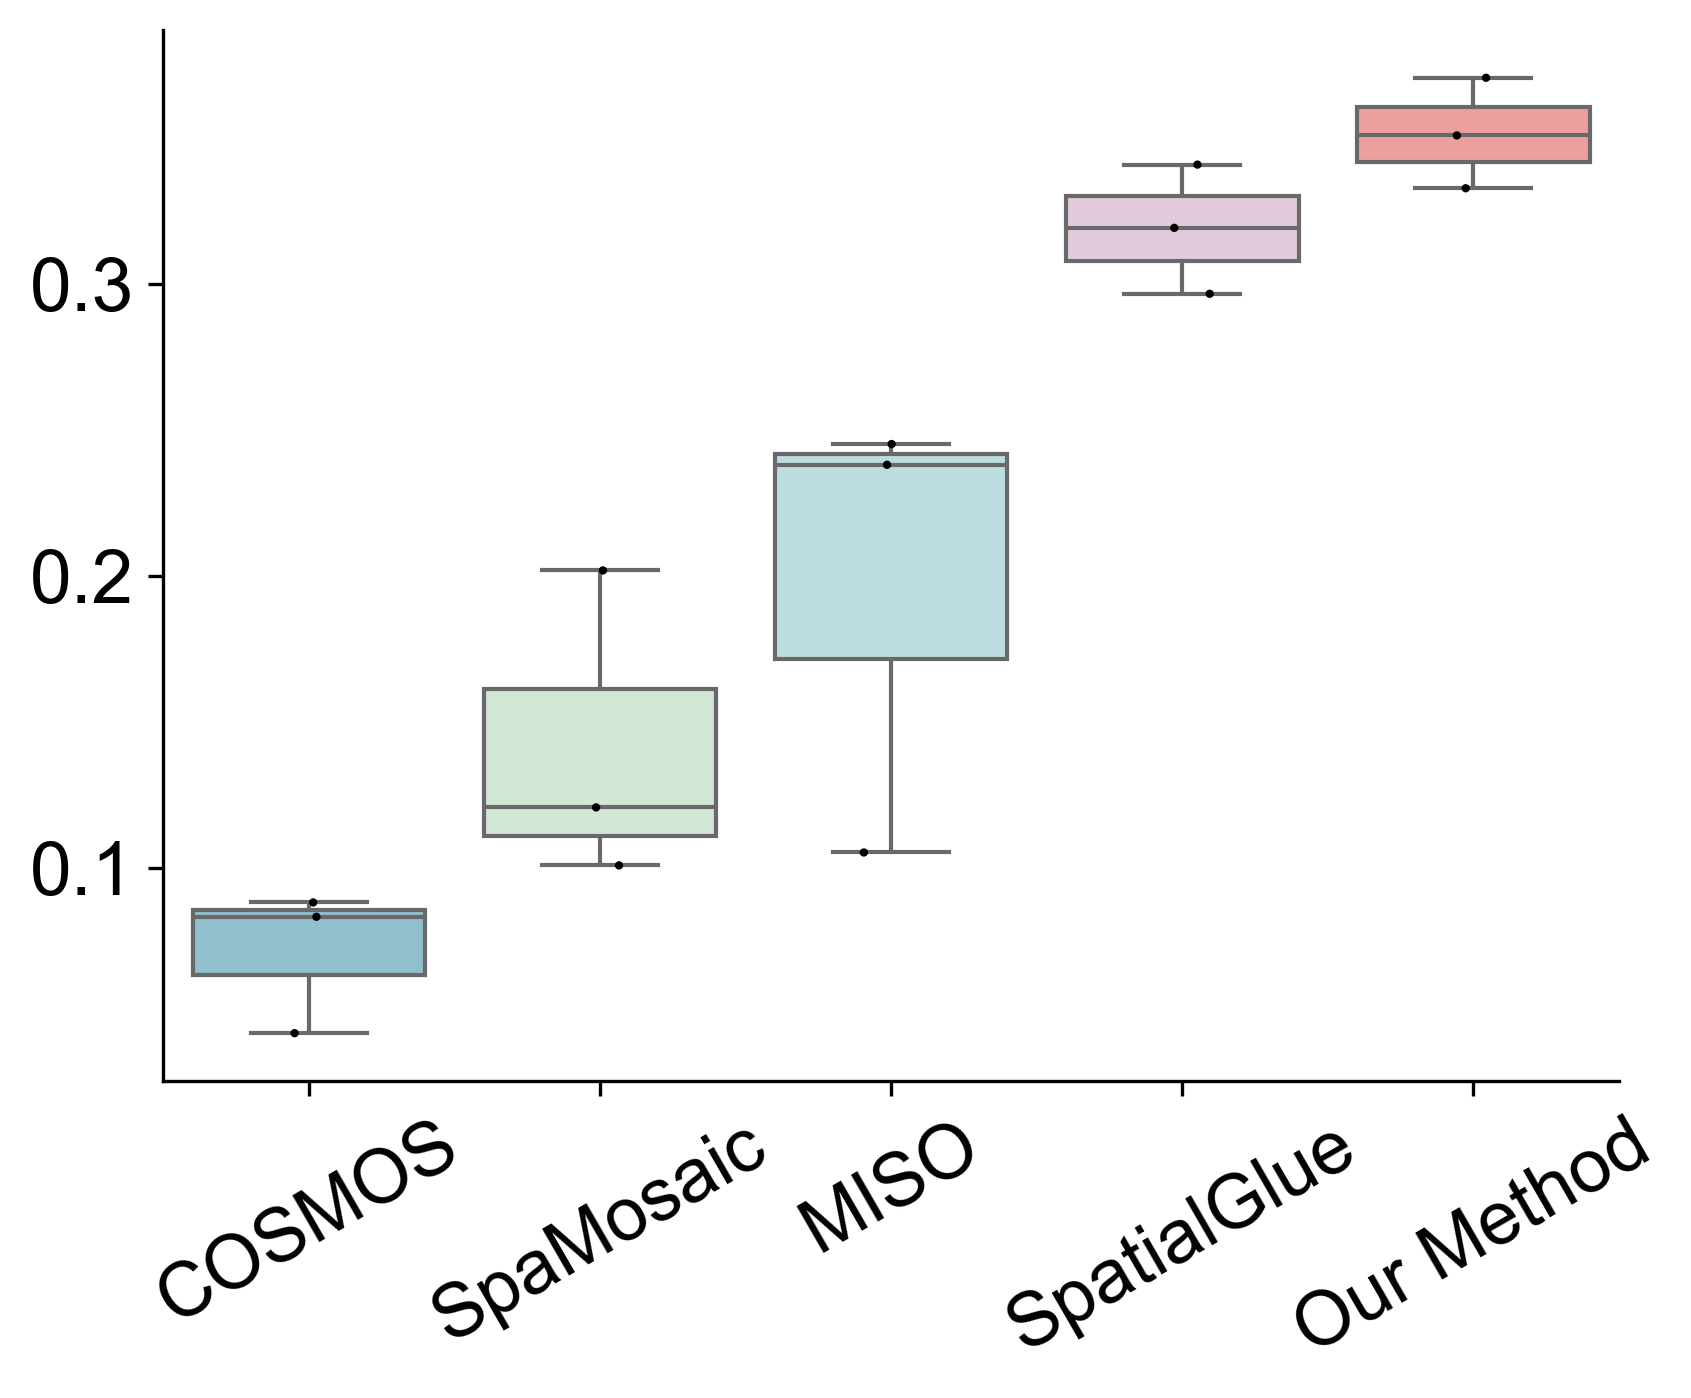

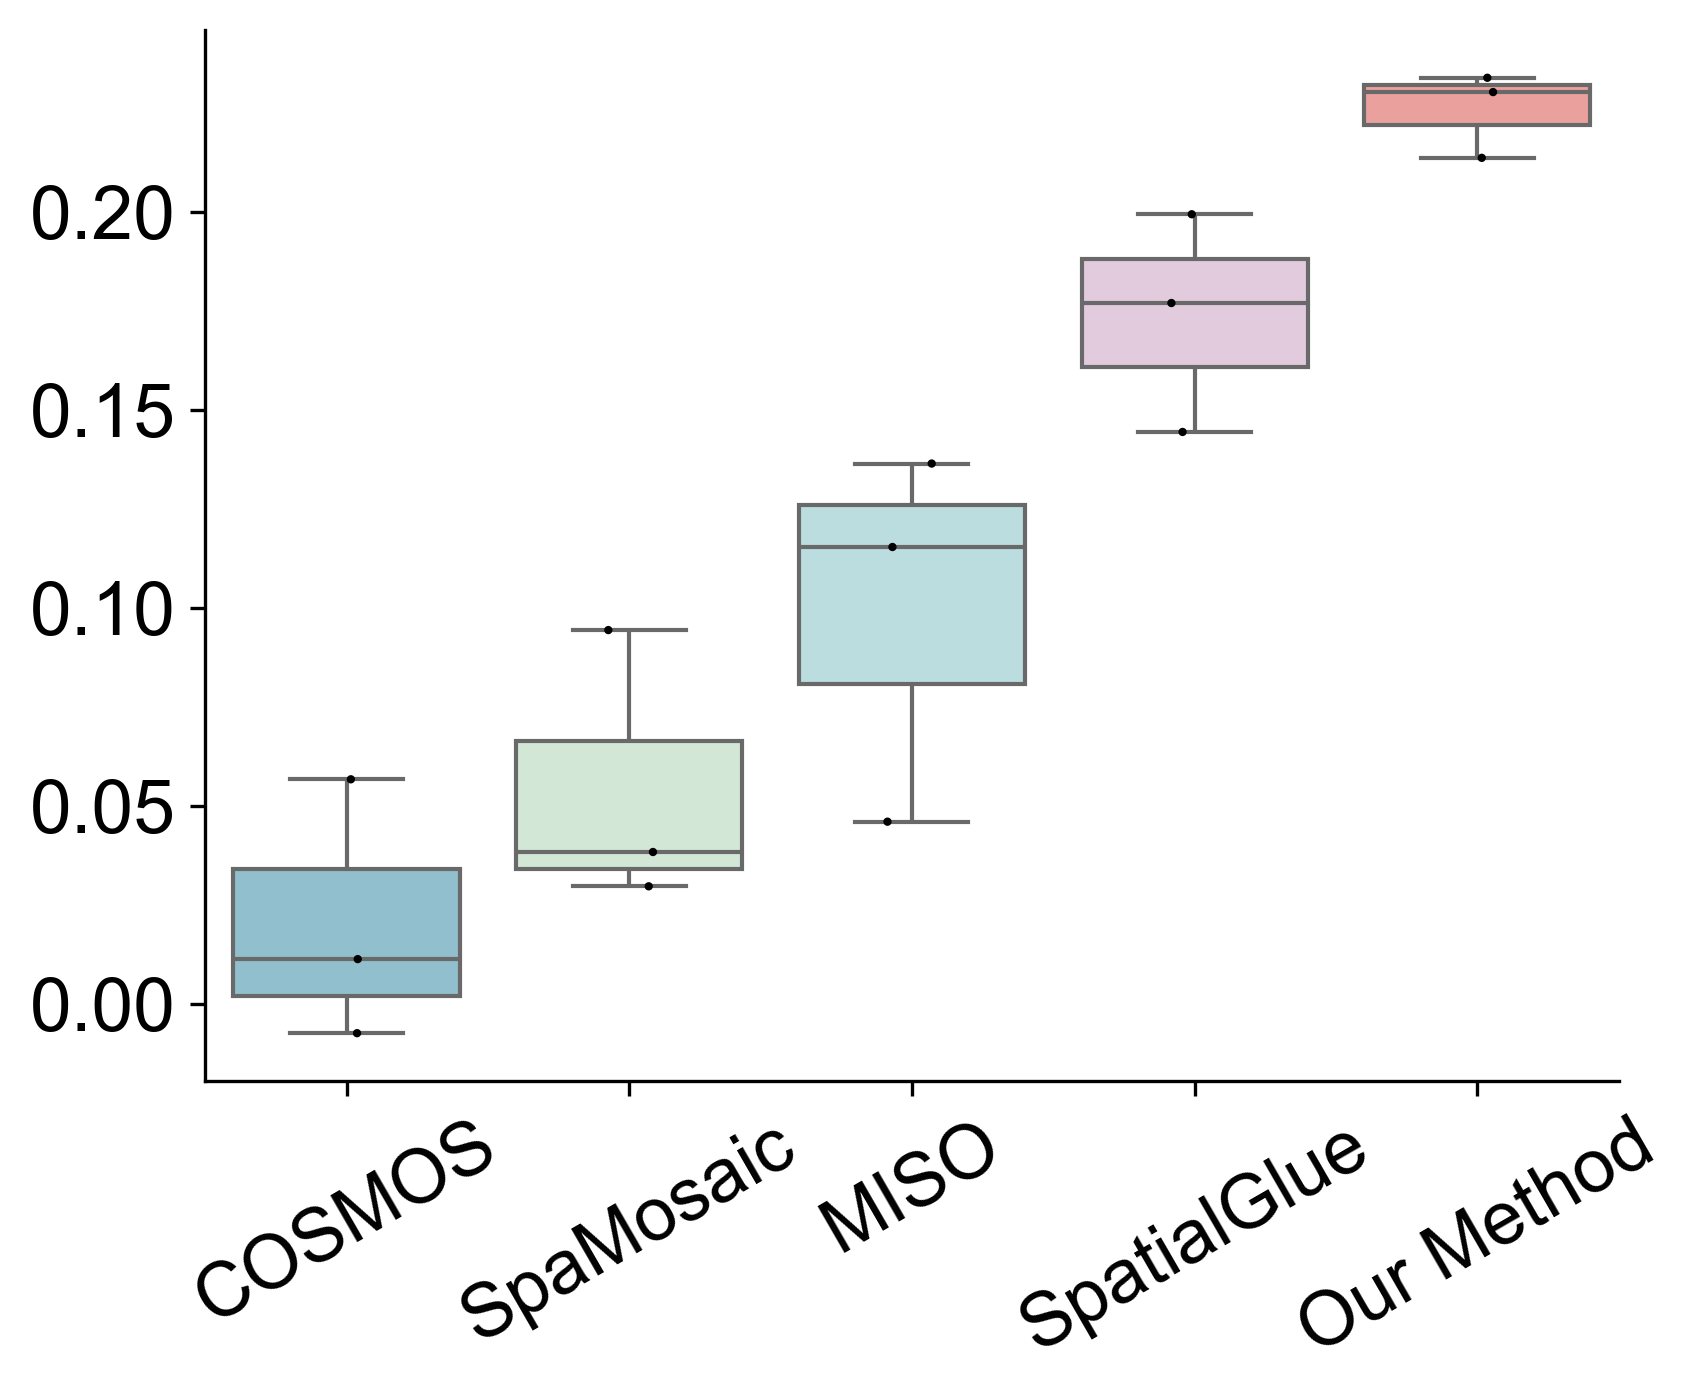

In [15]:

# 创建一个颜色字典，为每个方法指定颜色   "#88c4d7、#d0ead5、#b5e2e5、#9793c6、#e6c7df、#f79691  "
colors = {
    'COSMOS': '#88c4d7',
    'SpaMosaic': '#d0ead5',
    'MISO': '#b5e2e5',
    'SpatialGlue': '#e6c7df',
    'Our Method': '#f79691'
}

# 遍历每个指标，分别绘图
metrics = result_df['Metric'].unique()

for metric in metrics:
    plt.figure(figsize=(6, 5), dpi=300)
    
    # 筛选当前指标的数据
    metric_data = result_df[result_df['Metric'] == metric]
    
    # 绘制箱线图
    sns.boxplot(data=metric_data, x='Method', y='Value', palette=colors)
    
    # 叠加散点图
    sns.stripplot(data=metric_data, x='Method', y='Value', color='black', edgecolor='None', size=2, jitter=True, dodge=True)

    plt.title('')  # 清空标题
    plt.ylabel('')  # 清空y轴标签
    plt.xlabel('')  # 清空x轴标签
    plt.xticks(rotation=30)  # 旋转x轴刻度标签

    # 去掉边框
    # 仅保留x轴和y轴的线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)

    plt.tight_layout()
    plt.show()

### 图3：柱状图（带散点）--进阶版

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 创建一个颜色字典，为每个方法指定颜色
colors = {
    'COSMOS': '#88c4d7',
    'SpaMosaic': '#d0ead5',
    'MISO': '#b5e2e5',
    'SpatialGlue': '#e6c7df',
    'Our Method': '#f79691'
}

# 定义每个子图的矩形框参数
rect_params = [
    # 第一个子图的框参数
    [
        {'x': -0.45, 'y': 0.03, 'width': 3.9, 'height': 0.315, 'color': '#b5e2e5'},
        {'x': 3.56, 'y': 0.3, 'width': 0.88, 'height': 0.08, 'color': '#EE9185'}
    ],
    # 第二个子图的框参数
    [
        {'x': -0.45, 'y': 0.035, 'width': 3.9, 'height': 0.315, 'color': '#b5e2e5'},
        {'x': 3.56, 'y': 0.32, 'width': 0.88, 'height': 0.06, 'color': '#EE9185'}
    ],
    # 第三个子图的框参数
    [
        {'x': -0.45, 'y': 0.035, 'width': 3.9, 'height': 0.345, 'color': '#b5e2e5'},
        {'x': 3.56, 'y': 0.32, 'width': 0.88, 'height': 0.08, 'color': '#EE9185'}
    ],
    # 第四个子图的框参数
    [
        {'x': -0.45, 'y': 0.035, 'width': 3.9, 'height': 0.315, 'color': '#b5e2e5'},
        {'x': 3.56, 'y': 0.327, 'width': 0.88, 'height': 0.05, 'color': '#EE9185'}
    ],
    # 第五个子图的框参数
    [
        {'x': -0.45, 'y': -0.01, 'width': 3.9, 'height': 0.215, 'color': '#b5e2e5'},
        {'x': 3.56, 'y': 0.207, 'width': 0.88, 'height': 0.035, 'color': '#EE9185'}
    ]
]
print("✅ 矩形框参数已定义")

✅ 矩形框参数已定义


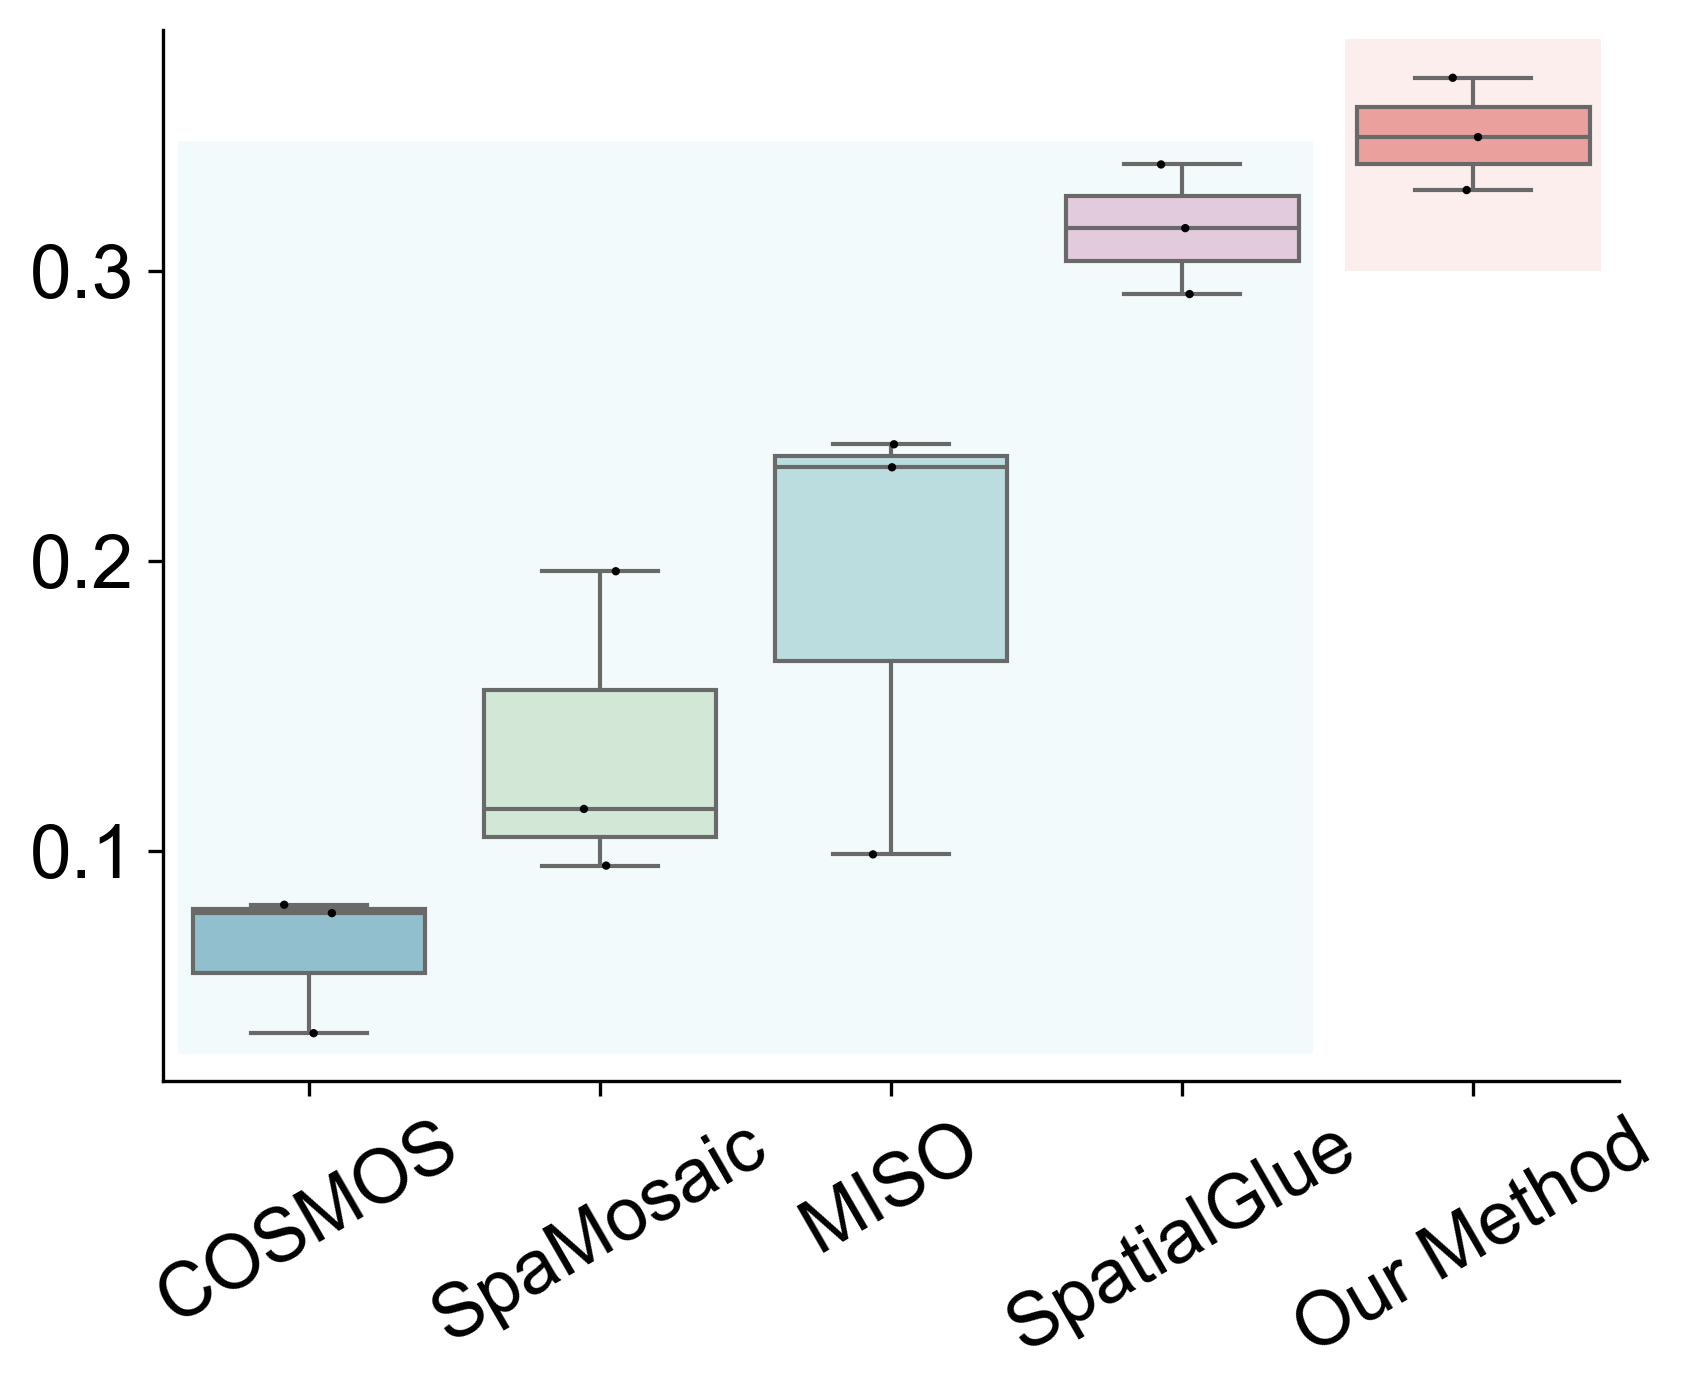

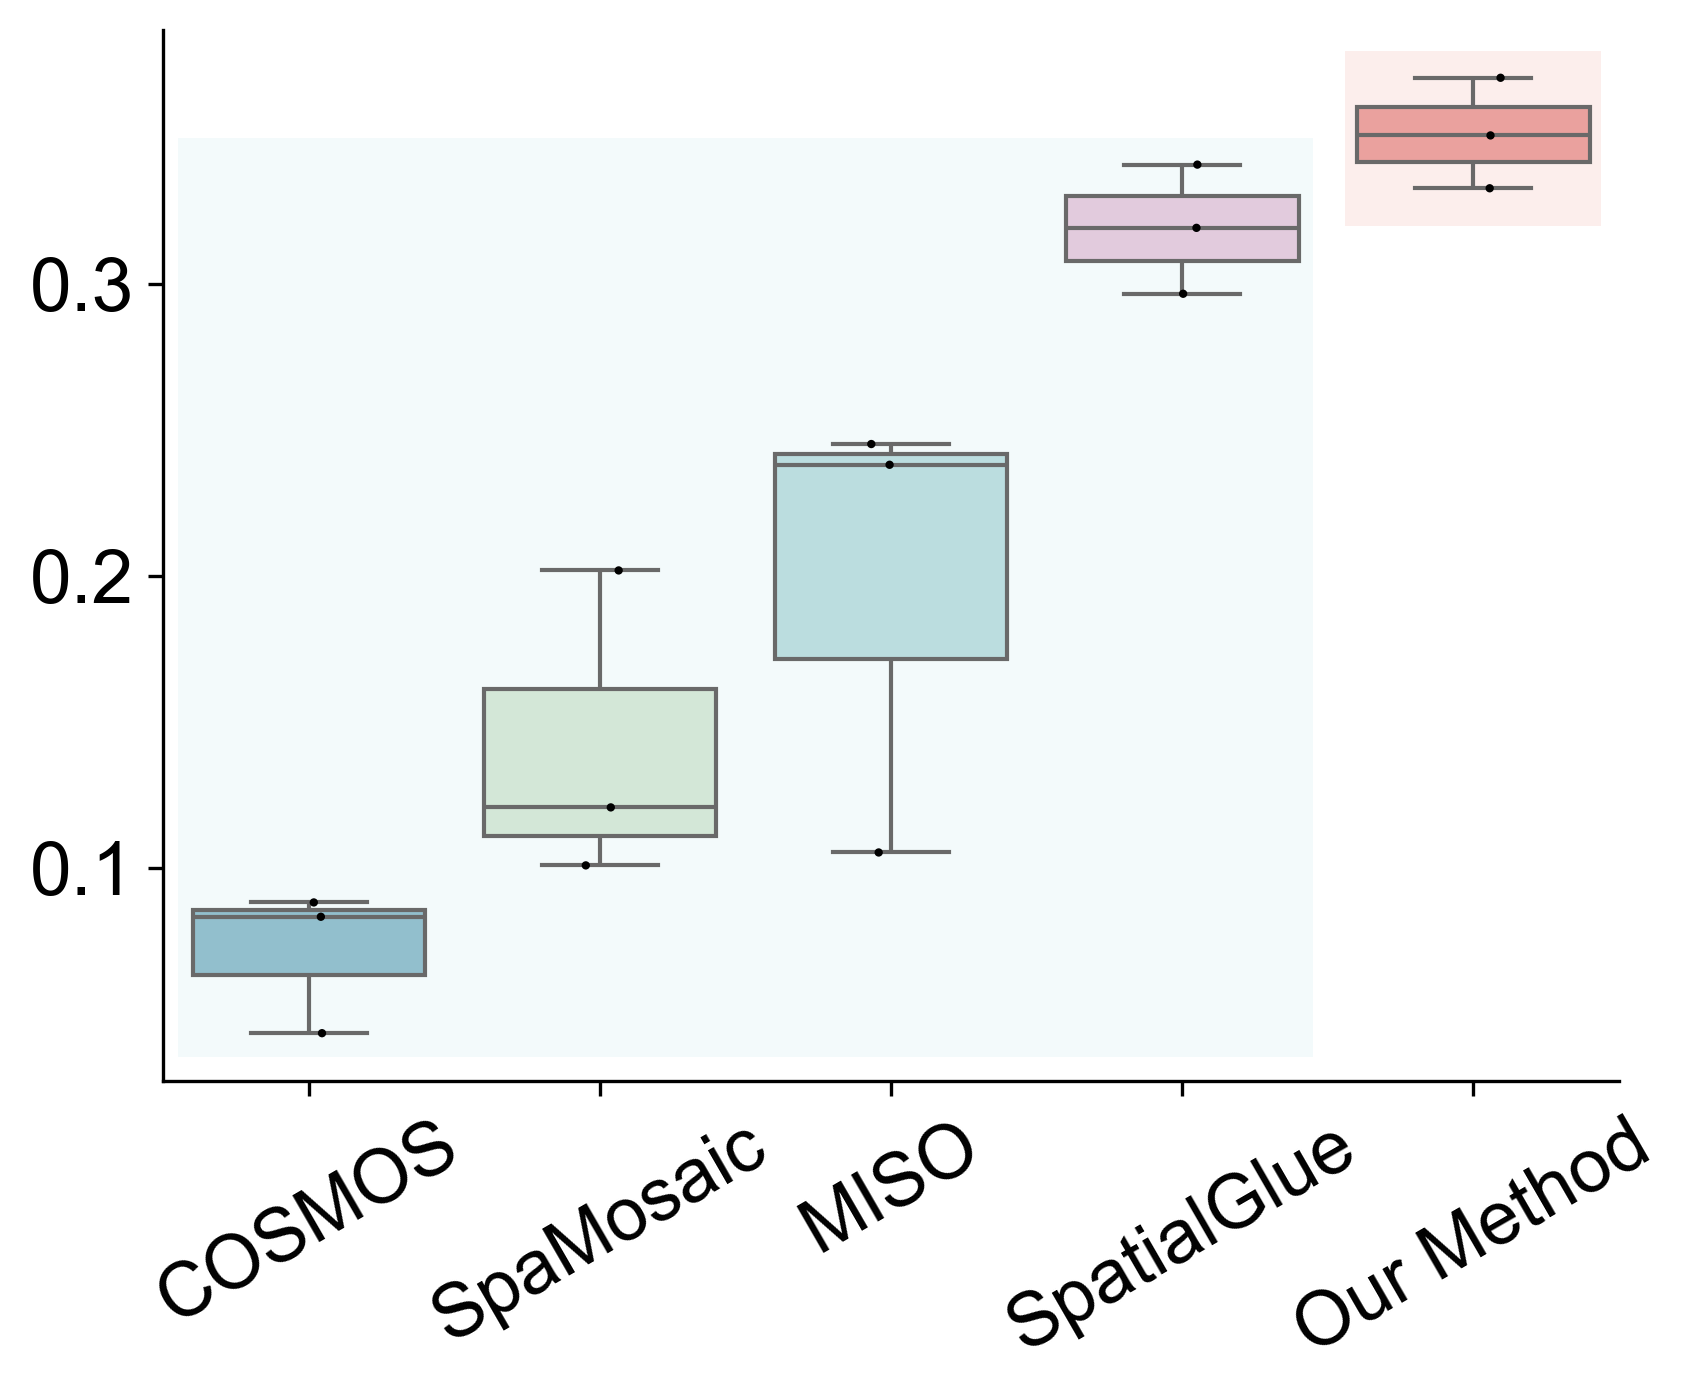

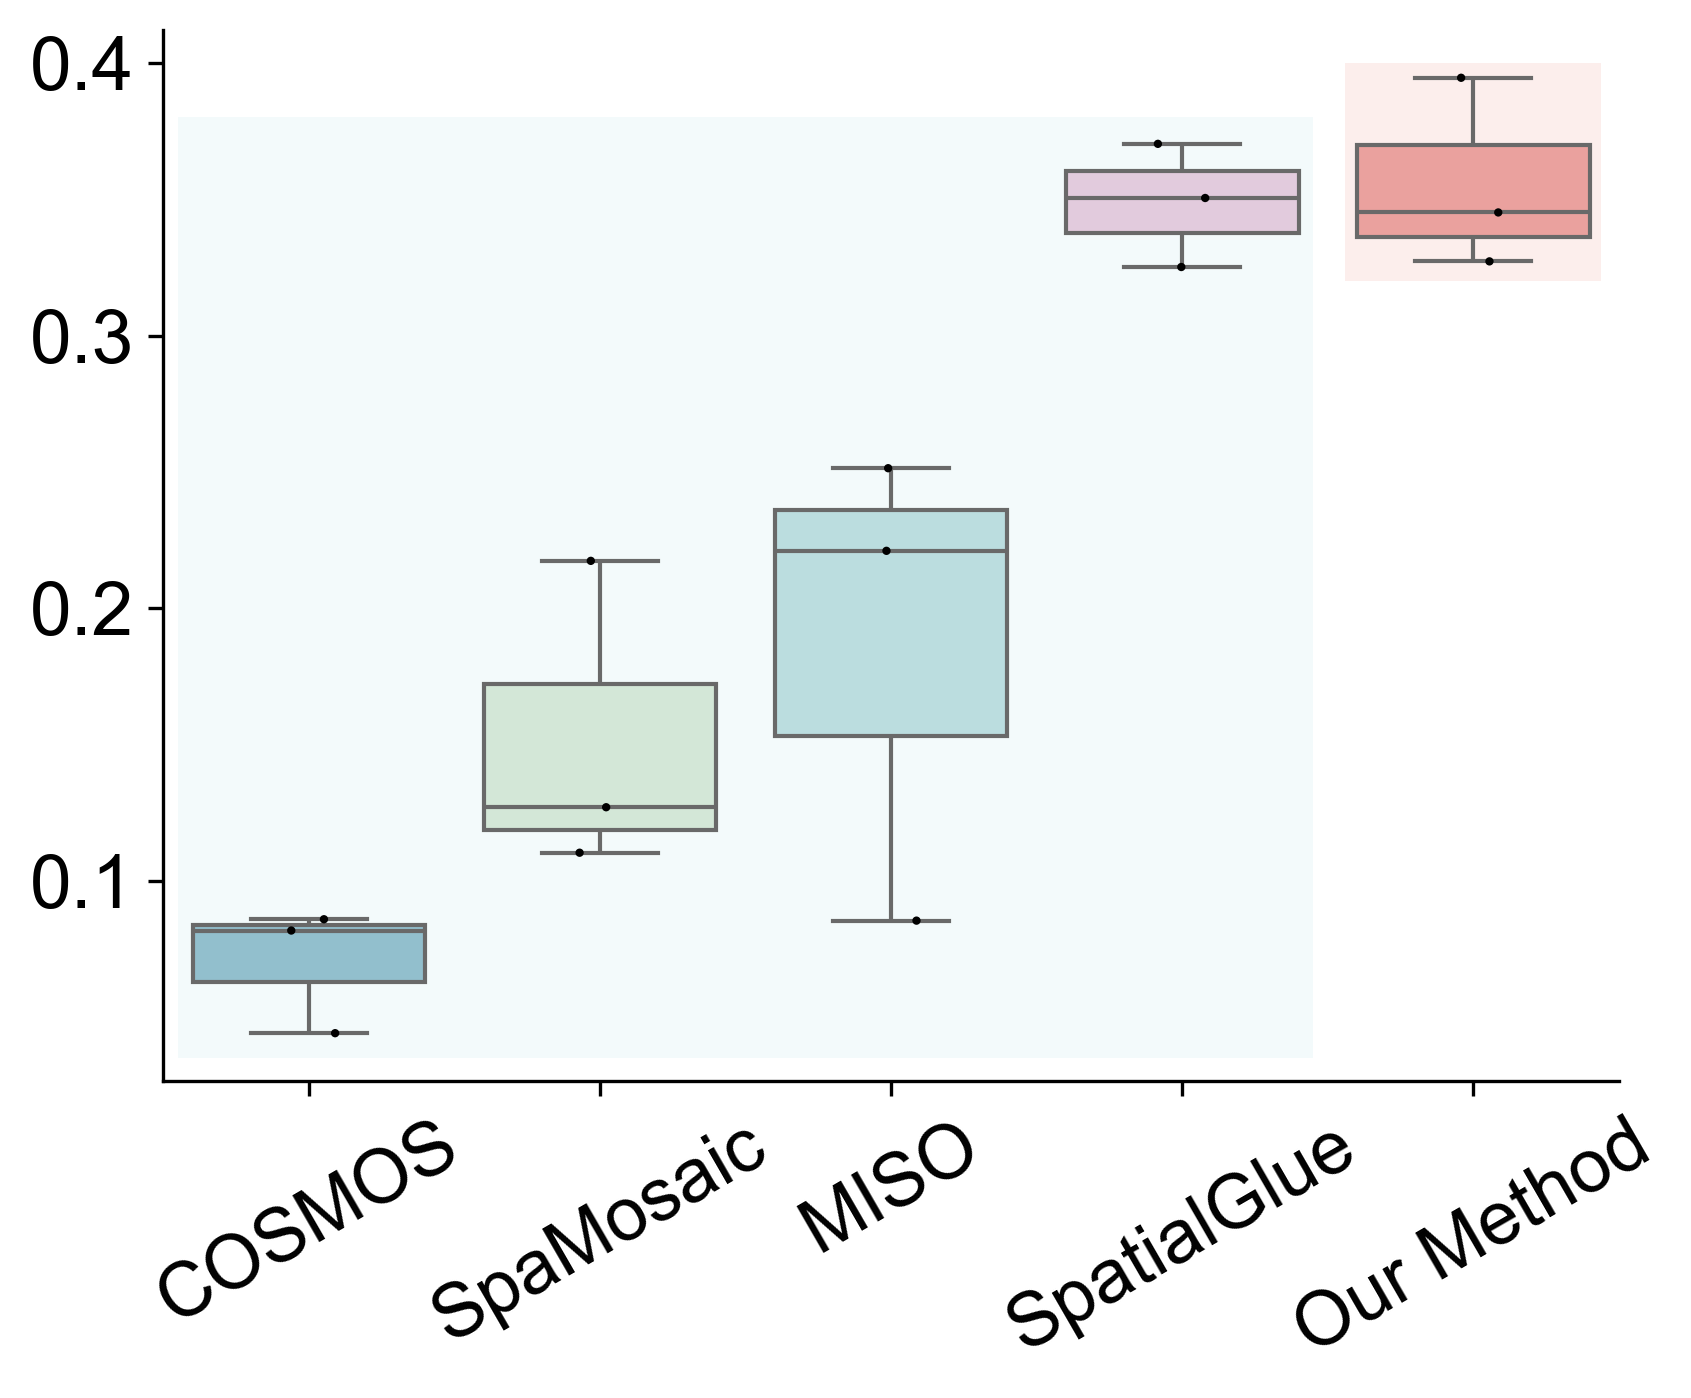

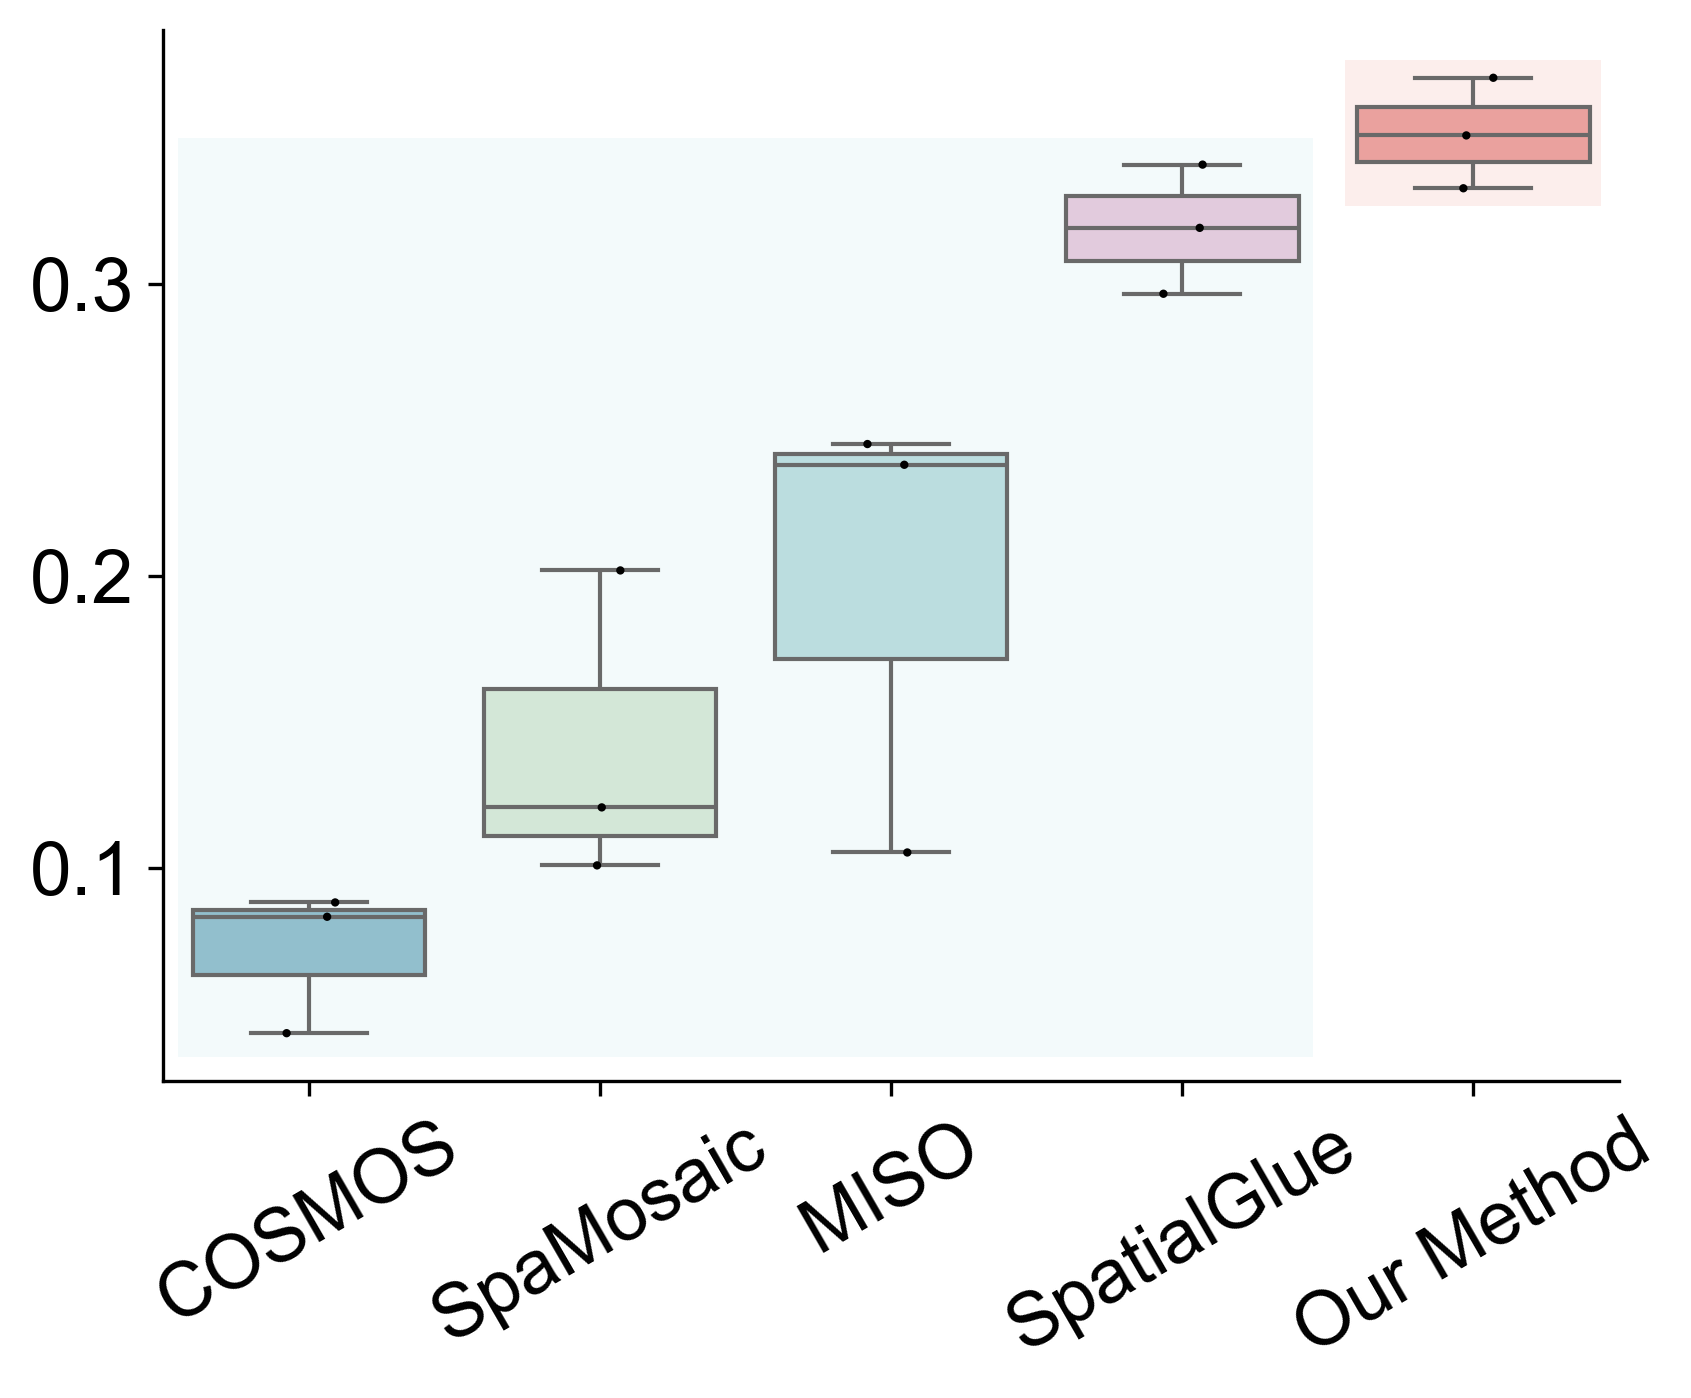

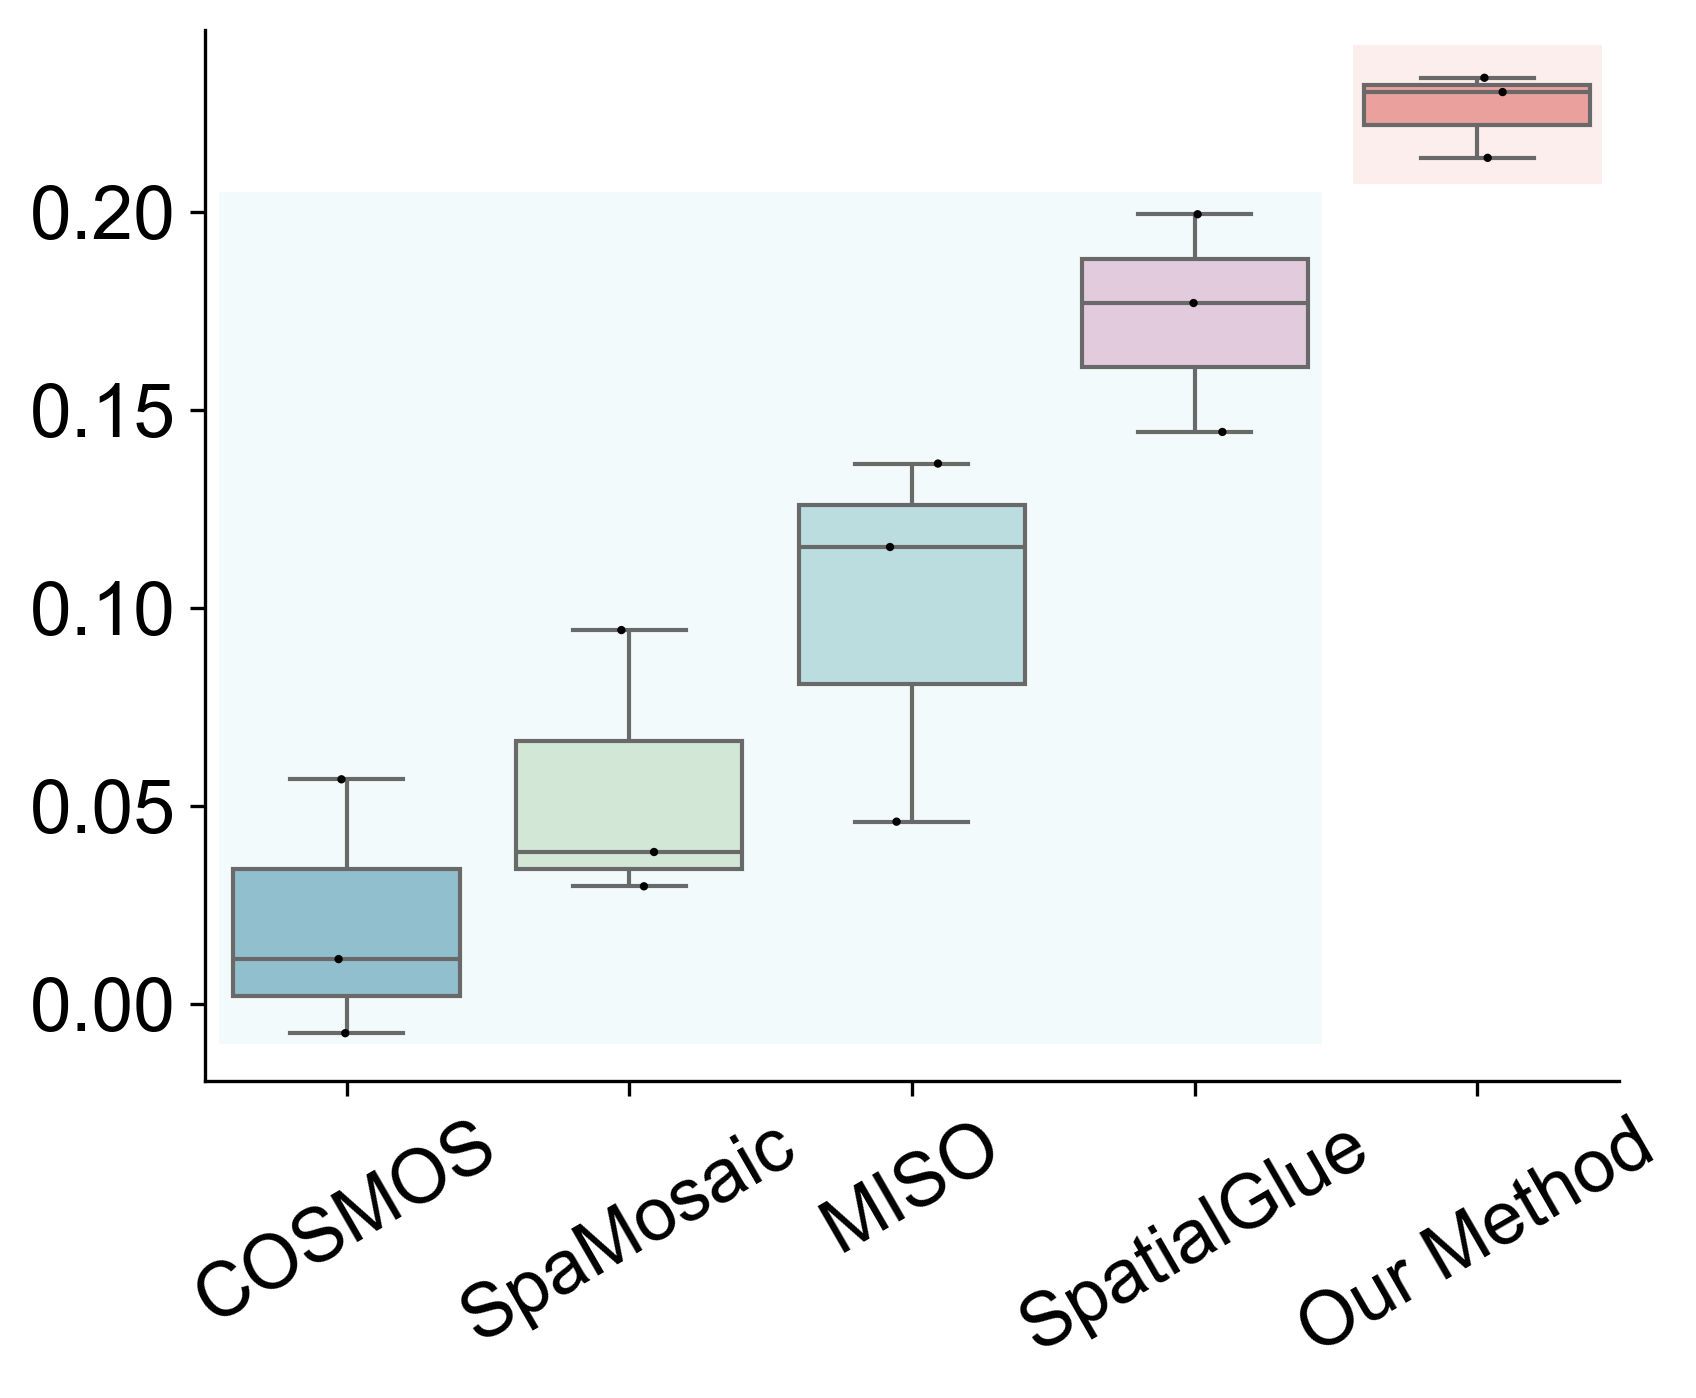

In [18]:


# 遍历每个指标，分别绘图
metrics = result_df['Metric'].unique()

for i, metric in enumerate(metrics):
    plt.figure(figsize=(6, 5), dpi=300)
    
    # 筛选当前指标的数据
    metric_data = result_df[result_df['Metric'] == metric]
    
    # 绘制箱线图
    sns.boxplot(data=metric_data, x='Method', y='Value', palette=colors)
    
    # 叠加散点图
    sns.stripplot(data=metric_data, x='Method', y='Value', color='black', edgecolor='None', size=2, jitter=True, dodge=True)

    plt.title('')  # 清空标题
    plt.ylabel('')  # 清空y轴标签
    plt.xlabel('')  # 清空x轴标签
    plt.xticks(rotation=30)  # 旋转x轴刻度标签

    # 去掉边框
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)

    # 获取当前轴
    ax = plt.gca()
    
    # 获取当前子图的框参数
    rect1_params, rect2_params = rect_params[i]
    
    # 添加第一个框
    rect1 = patches.Rectangle(
        (rect1_params['x'], rect1_params['y']),
        rect1_params['width'],
        rect1_params['height'],
        facecolor=rect1_params['color'],
        alpha=0.15,
        edgecolor='none',
        zorder=0
    )
    
    # 添加第二个框
    rect2 = patches.Rectangle(
        (rect2_params['x'], rect2_params['y']),
        rect2_params['width'],
        rect2_params['height'],
        facecolor=rect2_params['color'],
        alpha=0.15,
        edgecolor='none',
        zorder=0
    )
    
    # 添加矩形框到当前轴
    ax.add_patch(rect1)
    ax.add_patch(rect2)

    plt.tight_layout()
    plt.show()